### Import libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
from jenkspy import JenksNaturalBreaks
import statsmodels.api as sm
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

### Function to read the data

In [2]:
# Load the data
raw_data = pd.read_csv("DS_test_reformulation.csv", sep=";").drop(columns=["Unnamed: 0"])

### String to float conversion function

In [3]:
def str_to_float(value):
    # Replace ',' with '.' and convert to float
    return float(value.replace(',', '.'))

In [4]:
# Dictionary to convert the column 'device' to numeric
dictionary_to_number = {"mobile": 1, "laptop": 2}
# Map the values in the 'pricing_channel' column using the dictionary
raw_data['device'] = raw_data['device'].map(dictionary_to_number)
raw_data["percentual_price_increment"] = raw_data.percentual_price_increment.apply(str_to_float)
# Apply the str_to_float function to columns "profit_per_order" and "profit"
raw_data["profit_per_order"] = raw_data.profit_per_order.apply(str_to_float)
raw_data["profit"] = raw_data.profit.apply(str_to_float)
# Convert to date time the column "date"
raw_data['date'] = pd.to_datetime(raw_data['date'])

In [5]:
raw_data

,date,weekday,device,percentual_price_increment,traffic,orders,profit,profit_per_order
0,2022-01-01,6,1,0.150,2225,8,357.50,44.687500
1,2022-01-02,7,1,0.075,2348,15,712.50,47.500000
2,2022-01-03,1,1,-0.025,2473,49,1653.75,33.750000
3,2022-01-04,2,1,-0.050,2320,37,1435.00,38.783784
4,2022-01-05,3,1,-0.025,2762,56,2135.00,38.125000
...,...,...,...,...,...,...,...,...
995,2023-05-11,4,2,-0.100,2526,71,2080.00,29.295775
996,2023-05-12,5,2,0.100,1637,47,2480.00,52.765957
997,2023-05-13,6,2,0.025,2162,20,778.75,38.937500
998,2023-05-14,7,2,-0.200,2833,52,1580.00,30.384615


# Clean Data   

We want to filter out any rows with a 0% price increment, since that would result in an infinite elasticity value.  

We call the function on our raw data and save the result to `raw_data_cleaned`.  

This gives us `raw_data_cleaned`, our dataframe with rows of 0% price change filtered out, so we can go ahead and calculate elasticity without worrying about infinite values!

In [6]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:  
# Create a filter to remove rows with 0% ppi
    percentual_price_increment_filter = df["percentual_price_increment"] != 0  
# Filter the dataframe
    df_first_cleaned = df[percentual_price_increment_filter]
# Return a deep copy of the filtered dataframe
    return df_first_cleaned.copy(deep=True)

raw_data_cleaned = clean_data(raw_data)
raw_data_cleaned

,date,weekday,device,percentual_price_increment,traffic,orders,profit,profit_per_order
0,2022-01-01,6,1,0.150,2225,8,357.50,44.687500
1,2022-01-02,7,1,0.075,2348,15,712.50,47.500000
2,2022-01-03,1,1,-0.025,2473,49,1653.75,33.750000
3,2022-01-04,2,1,-0.050,2320,37,1435.00,38.783784
4,2022-01-05,3,1,-0.025,2762,56,2135.00,38.125000
...,...,...,...,...,...,...,...,...
995,2023-05-11,4,2,-0.100,2526,71,2080.00,29.295775
996,2023-05-12,5,2,0.100,1637,47,2480.00,52.765957
997,2023-05-13,6,2,0.025,2162,20,778.75,38.937500
998,2023-05-14,7,2,-0.200,2833,52,1580.00,30.384615


# Calculate Price Elasticity Slope  

We want to calculate the slope of the price elasticity for different segments of data, so we can see how elasticity changes with price changes.

We call the function on grouped data and save the result.

The function fits a simple OLS regression model to each segment group, with percentual_price_increment as the independent variable and response as the dependent variable.  

It returns the slope and intercept of the fitted model, giving us the elasticity slope and baseline response for each segment.  

We can now analyze how elasticity differs across customer segments and price ranges.

In [7]:
def get_price_elasticity_slope(group: pd.DataFrame) -> dict: 
# Get the ppi column as the independent variable X
    X = group[['percentual_price_increment']]  
# Get the response column as the dependent variable y
    y = group["response"]
# Fit a linear OLS regression model 
    model = sm.OLS(y, sm.add_constant(X)).fit()
# Get the intercept parameter from the model
    intercept = model.params[0]  
# Get the slope parameter from the model
    slope = model.params[1]
# Return the slope and intercept in a dictionary
    return {"slope": slope, "intercept": intercept}

# Plot Price Response Functions

We plot the percentual_price_increment vs response data for each segment group. We also plot a linear price response line based on the calculated slope and intercept.

By analyzing the scatter plots and response lines, we can see differences in elasticity across segments. Steeper slopes indicate higher price sensitivity, while flatter slopes indicate lower sensitivity.

In [8]:
def plotter(group: pd.DataFrame, price_elasticity_slope: dict) -> None:  
# Create a figure 
    fig = plt.figure()  
# Linearly space x values from min to max ppi
    x = np.linspace(group['percentual_price_increment'].min(), group['percentual_price_increment'].max()) 
# Get the slope and intercept from the regression model
    intercept = price_elasticity_slope["intercept"] 
    slope = price_elasticity_slope["slope"]
# Calculate the y values for the line 
    y = intercept + slope * x
# Plot the actual data as a scatter plot 
    plt.scatter(
        group['percentual_price_increment'], group['response'],
        label=f"Segment {(group.weekday.iloc[0], group.device.iloc[0])}"
    )  
# Plot the regression line 
    plt.plot(x, y, color='red', label=f"Linear Price Response")  
# Add axis labels
    plt.xlabel('Price')  
    plt.ylabel('Response')  
# Add a title 
    plt.title('Linear Price Response Function')
# Add a legend
    plt.legend()  
# Save the figure 
    plt.savefig('linear_response.png')

# Analyze Price Elasticity   

The function first sorts the data by date.  

It then calculates the percentage change in orders from the previous row, saving this as the `response` column. 

Next, it divides the response by the percentage price increment (ppi) to get the price elasticity. The elasticity shows us how sensitive demand is to a given price change.

The segments are defined by (weekday, device) tuples, giving us natural segments based on when clients are buying (weekday) and what device they are using (device).

The ppi is the percentage price increment, referring to the price increase (or decrease) from the previous period. By dividing the response (change in orders) by the ppi, we get the price elasticity, which shows by what factor demand changes for a given percentage price change.  

The remaining lines prepare the plot and summary dataframe.  

A key metric is `ppi_that_maximize_profit`, which filters the data to find the ppi where profit was maximized for each segment. By setting the price at this ppi, we can optimize revenue for each customer group.

In [9]:
def analysis(group):  
# Sort the data by date  
    group_sorted = group.sort_values(by="date")  
# Calculate the percentage change in orders 
    group_sorted["response"] = group_sorted["orders"].pct_change()   
# Calculate the price elasticity by dividing the response by ppi
    group_sorted["price_elasticity"] = group_sorted["response"] / group_sorted["percentual_price_increment"]  
# Drop null values 
    group_sorted.dropna(inplace=True)
# Get the slope of the price elasticity curve
    price_elasticity_slope_dict = get_price_elasticity_slope(group_sorted)  
# Create a dataframe with key summary metrics for the segment
    data = pd.DataFrame([{  
        "segm": (group_sorted.weekday.iloc[0], group_sorted.device.iloc[0]), 
        "price_elasticity_mean": group_sorted["price_elasticity"].mean(),
# Find the ppi that maximized profit 
        "ppi_that_maximize_profit": group_sorted[  
            group_sorted['profit'] == group_sorted['profit'].max()
        ]["percentual_price_increment"].iloc[0],  
        "sum_profit": group_sorted.profit.sum(),
        "sum_traffic": group_sorted.traffic.sum()  
    }])
# Plot the price response curve 
    plotter(group_sorted, price_elasticity_slope_dict)  
    return data

,segm,price_elasticity_mean,ppi_that_maximize_profit,sum_profit,sum_traffic
0,"(2, 1)",0.168488,0.200,92561.25,148082
1,"(5, 2)",-0.296991,0.175,184147.50,147383
2,"(1, 1)",-0.337669,0.100,111126.25,162118
3,"(1, 2)",-0.654462,0.200,104857.50,148107
4,"(2, 2)",-0.822942,0.175,93026.25,149291
5,"(5, 1)",-1.160274,0.150,187920.00,153774
6,"(3, 1)",-1.220388,0.025,110330.00,153702
7,"(4, 1)",-1.235212,0.125,154531.25,150502
8,"(3, 2)",-1.834472,0.125,106145.00,155493
9,"(4, 2)",-2.570127,0.025,151917.50,153464


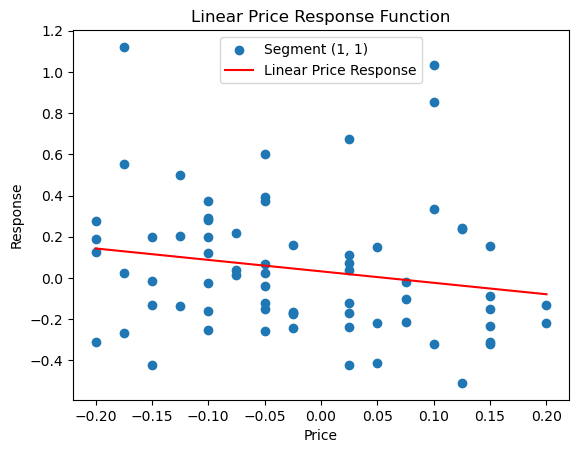

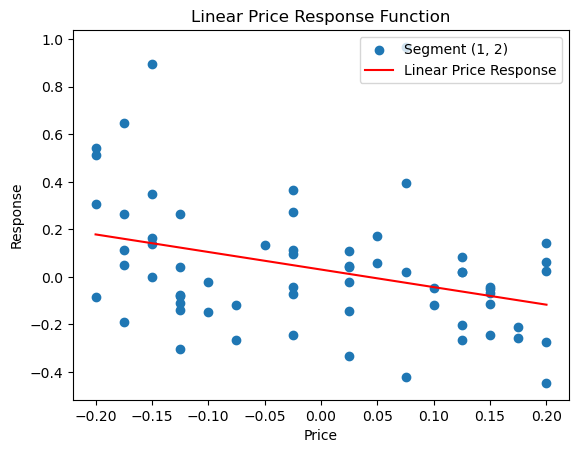

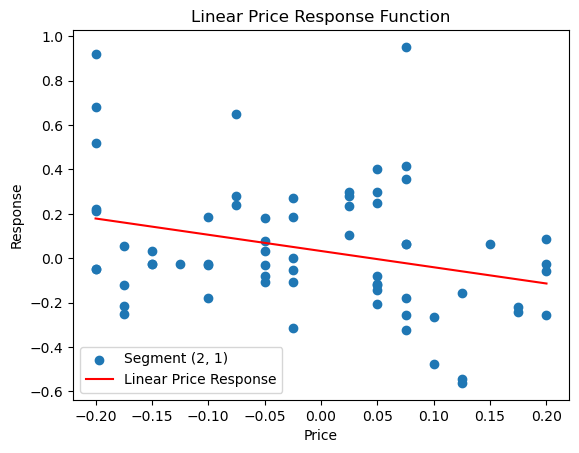

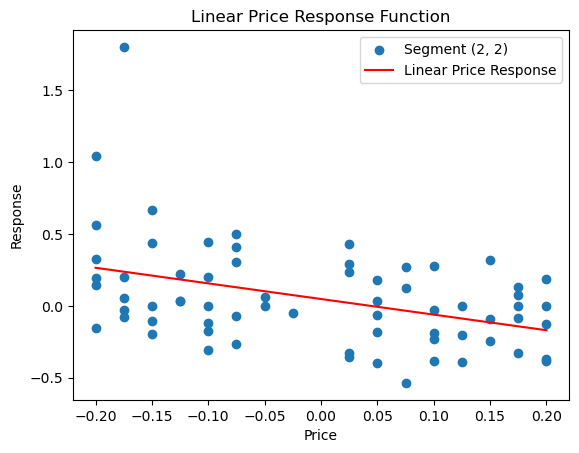

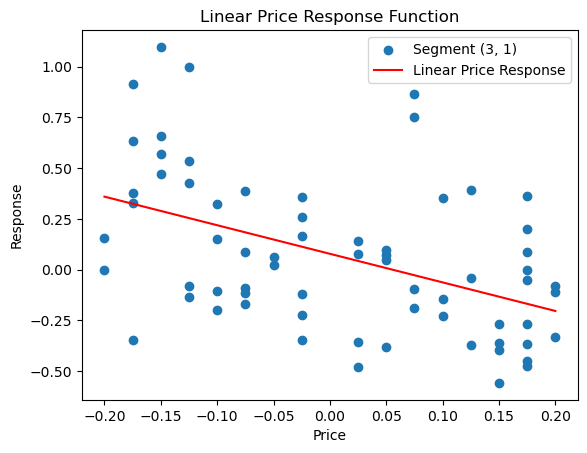

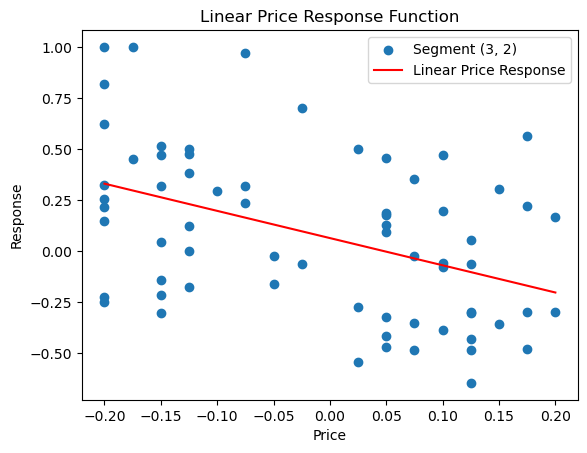

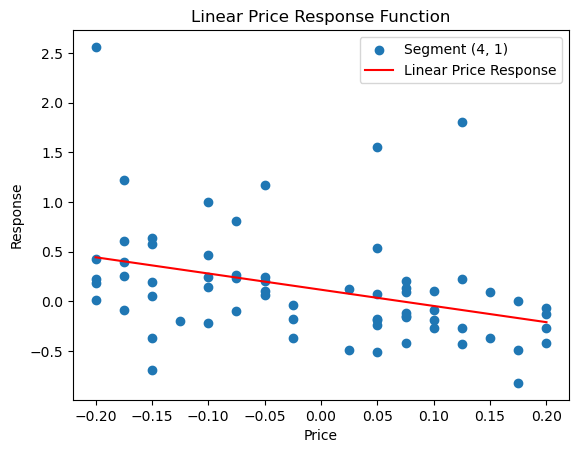

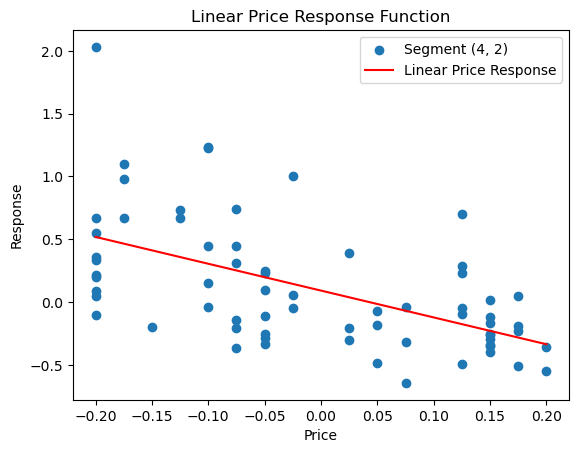

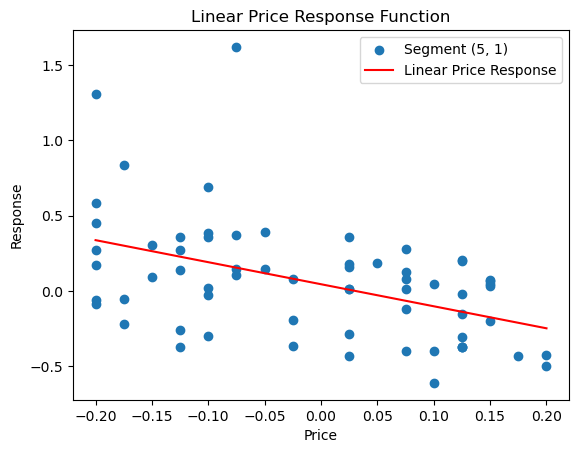

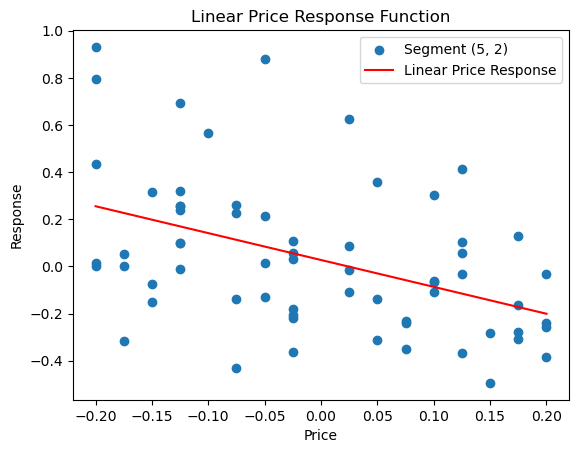

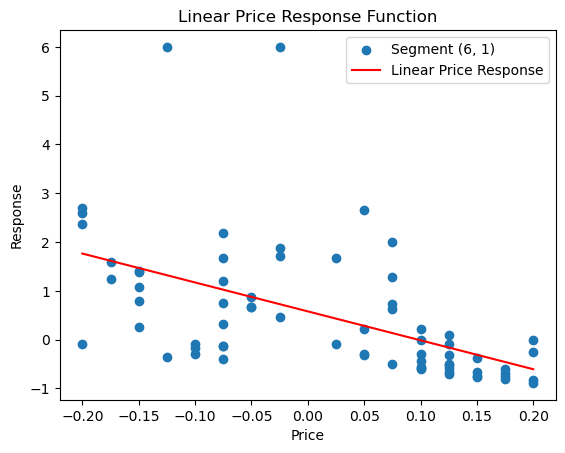

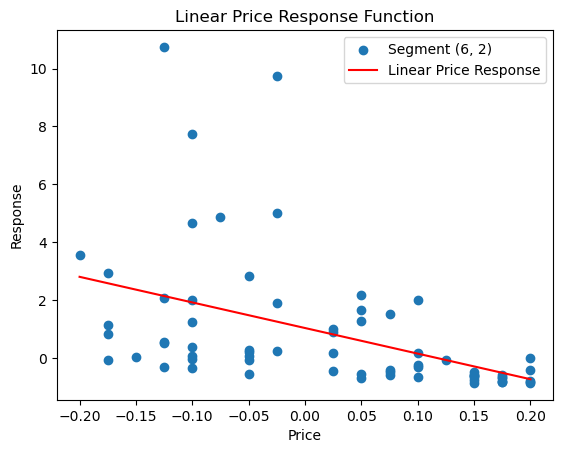

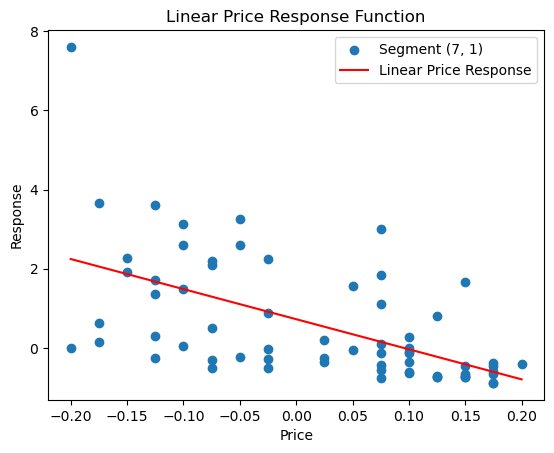

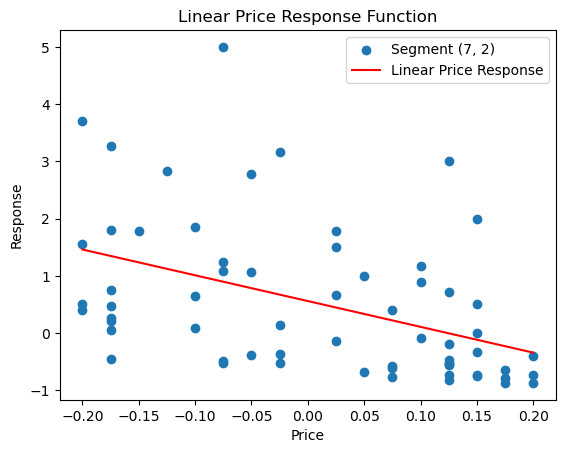

In [10]:
# Group by weekday and device 
raw_data_clusterized = raw_data_cleaned.groupby(["weekday", "device"]).apply(analysis) 

# Sort by price elasticity mean in descending order
raw_data_clusterized_sorted = raw_data_clusterized.sort_values(by="price_elasticity_mean", ascending=False).reset_index(drop=True) 

# View the sorted, clustered dataframe
raw_data_clusterized_sorted

# Apply Natural Breaks Clustering

The `jenks_natural_breaks` function uses the Jenks Natural Breaks algorithm to cluster the price elasticity means into natural groups. We specify the target number of clusters, and the algorithm finds the best breaks.

The function returns a dictionary mapping each cluster ID to its group label. We can analyze metrics and pricing strategies for each price sensitivity cluster.

Clustering reveals insights we may miss otherwise and opportunities to tailor pricing to different customer groups. Data-driven segmentation leads to more effective decision making. 

In [11]:
def jenks_natural_breaks(df: pd.DataFrame, final_grouped_clusters: int) -> dict:  
# Create a dictionary to map cluster labels 
    label_dict = {}  
# Use the Jenks Natural Breaks algorithm from ClusterPy 
    jnb = JenksNaturalBreaks(final_grouped_clusters)  
# Fit the model on the price elasticity means
    jnb.fit(df.price_elasticity_mean)  
# Get the cluster label for each data point
    for cluster_id, label in enumerate(jnb.labels_):  
# Add the label to the dictionary 
        label_dict[cluster_id] = label
    return label_dict

# Cluster Price Sensitivity and Analyze Clusters   

We want to gain insights into different levels of price sensitivity in our customer base so we can tailor pricing strategies for each group. We first cluster the data into 3 groups - inelastic, medium, and elastic price sensitivity. 

We map the cluster IDs to descriptive labels:

- **Inelastic**: Price insensitive, less responsive to price changes. We can likely increase prices without significantly impacting demand from this group.  
- **Medium**: Moderately price sensitive. We need to be cautious with price changes for this group.   
- **Elastic**: Highly price sensitive, very responsive to price changes. We need to be very careful increasing prices for this group to not lose demand.

In [12]:
# Get cluster labels 
label_dict = jenks_natural_breaks(raw_data_clusterized_sorted, 3)  

# Map cluster IDs to descriptions
label_dict_desc = {0: 'inelastic', 1: 'medium', 2: 'elastic'}  

# Assign cluster label to each data point
raw_data_clusterized_sorted['cluster'] = [label_dict_desc[label_dict[i]] for i in range(len(raw_data_clusterized_sorted))]

# Sort by sum_profit to see most profitable clusters at top
raw_data_clusterized_sorted.sort_values(by="sum_profit", ascending=False)

,segm,price_elasticity_mean,ppi_that_maximize_profit,sum_profit,sum_traffic,cluster
5,"(5, 1)",-1.160274,0.150,187920.00,153774,elastic
1,"(5, 2)",-0.296991,0.175,184147.50,147383,elastic
7,"(4, 1)",-1.235212,0.125,154531.25,150502,elastic
9,"(4, 2)",-2.570127,0.025,151917.50,153464,elastic
2,"(1, 1)",-0.337669,0.100,111126.25,162118,elastic
6,"(3, 1)",-1.220388,0.025,110330.00,153702,elastic
8,"(3, 2)",-1.834472,0.125,106145.00,155493,elastic
3,"(1, 2)",-0.654462,0.200,104857.50,148107,elastic
4,"(2, 2)",-0.822942,0.175,93026.25,149291,elastic
0,"(2, 1)",0.168488,0.200,92561.25,148082,elastic


# Update Pricing to Maximize Profit  

Once we have clustered customers by price sensitivity and analyzed the most profitable groups, we want to update pricing to optimize profit across the entire customer base. This function updates the `ppi_that_maximize_profit` for all clusters to the ppi that maximized profit for the single most profitable cluster.

The function first finds the maximum sum_profit value. It then gets the ppi_that_maximize_profit for the row with that maximum profit.Finally, it updates ppi_that_maximize_profit to that value for all rows in the dataframe.

In [13]:
def update_percentual_price_increment_agg(df: pd.DataFrame) -> pd.DataFrame:  
# Find the maximum sum_profit value
    max_profit = df['sum_profit'].max()  
# Get the ppi_that_maximize_profit for the row with the max profit
    value = df.loc[df['sum_profit'] == max_profit, 'ppi_that_maximize_profit'].values[0]  
# Update ppi_that_maximize_profit to that value for all rows
    df['ppi_that_maximize_profit'] = value  
# Return the updated dataframe
    return df

In [17]:
# Group by cluster and update ppi_that_maximize_profit  
raw_data_max_profit = raw_data_clusterized_sorted.groupby('cluster').apply(update_percentual_price_increment_agg)

# Sort by updated sum_profit in descending order
raw_data_max_profit.sort_values(by="sum_profit", ascending=False).reset_index(drop=True)

,segm,price_elasticity_mean,ppi_that_maximize_profit,sum_profit,sum_traffic,cluster
0,"(5, 1)",-1.160274,0.150,187920.00,153774,elastic
1,"(5, 2)",-0.296991,0.150,184147.50,147383,elastic
2,"(4, 1)",-1.235212,0.150,154531.25,150502,elastic
3,"(4, 2)",-2.570127,0.150,151917.50,153464,elastic
4,"(1, 1)",-0.337669,0.150,111126.25,162118,elastic
5,"(3, 1)",-1.220388,0.150,110330.00,153702,elastic
6,"(3, 2)",-1.834472,0.150,106145.00,155493,elastic
7,"(1, 2)",-0.654462,0.150,104857.50,148107,elastic
8,"(2, 2)",-0.822942,0.150,93026.25,149291,elastic
9,"(2, 1)",0.168488,0.150,92561.25,148082,elastic
